In [1]:
!pip install pickle-mixin

import pickle
import pandas as pd
import numpy as np
from datetime import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt


with open('/content/drive/MyDrive/df_secured3.pickle', 'rb') as f:
    data = pickle.load(f)

with open('/content/drive/MyDrive/df_3.pickle', 'rb') as f:
    df = pickle.load(f)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
def positive_score(dic):
  return dic['positive']

def choose_pn(df):
  df['positive_score'] = df['labels_sh'].apply(positive_score)

choose_pn(df)

In [3]:
df_0 = df[['positive_score']]
# 감정분석 결과만 추출
data = pd.concat([data,df_0],axis=1,join='outer')
# 원본데이터에 추출한 데이터 합침 (index기준)


data['created_at'] = pd.to_datetime(data['created_at'])
# 오브젝트 타입 자료형을 datetime 자료형으로 변환


data['트위치'].fillna(0, inplace = True)
data = data.astype({'트위치':'int'})
# 트위치 컬럼 결측치 제거 및 인트화

data['아프리카(애청자/팬클럽)'].fillna(0, inplace = True)
data['아프리카(애청자/팬클럽)'] = data['아프리카(애청자/팬클럽)'].replace('15,777/11542', '15777')
data['아프리카(애청자/팬클럽)'] = data['아프리카(애청자/팬클럽)'].replace('13,763/2430', '13763')
data['아프리카(애청자/팬클럽)'] = data['아프리카(애청자/팬클럽)'].replace('171,372/18,901', '171372')
data['아프리카(애청자/팬클럽)'] = data['아프리카(애청자/팬클럽)'].replace('9,069/1,848', '9069')
data['아프리카(애청자/팬클럽)'] = data['아프리카(애청자/팬클럽)'].replace('1,600/1,135', '1600')
data['아프리카(애청자/팬클럽)'] = data['아프리카(애청자/팬클럽)'].replace('4.7천', '4700')
data['아프리카(애청자/팬클럽)'] = data['아프리카(애청자/팬클럽)'].replace('2,663/2,659', '2663')
data['아프리카(애청자/팬클럽)'] = data['아프리카(애청자/팬클럽)'].replace('1.9천', '1900')
data = data.astype({'아프리카(애청자/팬클럽)':'int'})
# 아프리카 컬럼 결측치 제거 및 데이터 단일화(?) 그리고 자료형 인트화
# 트위치의 팔로워 개념과 같은 애청자(즐겨찾기)만 남겨놓음

data['유튜브 수'].fillna(0, inplace = True)
data['유튜브 수'] = data['유튜브 수'].replace('?', '0')
data = data.astype({'유튜브 수':'int'})
# 유튜브 컬럼 결측치 제거 및 전처리 그리고 자료형 인트화


data = data[~data['message'].str.contains('님이 참여했습니다.')]
data = data[~data['message'].str.contains('님이 나갔습니다.')]
# 자동으로 입력되어 진짜 메세지가 아닌 '참여했습니다'와 '나갔습니다'를 제거

In [4]:
idtype_fan = data[data['id type']=='fan']
idtype_celeb = data[data['id type']=='celeb']
# id타입이 팬인것과 셀럽인것

celeb_file = data[(data['id type']=='celeb')&(data['type']=='FILE')]



fan_file = data[(data['id type']=='fan')&(data['type']=='FILE')]
fan_file2 = fan_file[fan_file['message'].str.contains('cdn.fancim')]
# 아이디타입이 팬이면서 파일인것중
# 보낸메세지가 스티커인것들만 추려서


ch_name_celeb_file = celeb_file.groupby(["channel_name_secured"]).agg({"message":"count"})
# 셀럽이 보낸 파일(음성,이미지등)개수 채팅방별


ch_name_sticker = fan_file2.groupby(["channel_name_secured"]).agg({"message":"count"})
# 그룹바이로 채널이름별 메세지수
# 채팅방별 보낸 스티커수, 보낸사람


ch_name_send_celeb = idtype_celeb.groupby(["channel_name_secured"]).agg({"message":"count"})
# 채팅방별 메세지수(셀럽이 보낸)
ch_name_send_fan = idtype_fan.groupby(["channel_name_secured"]).agg({"message":"count"})
# 채팅방별 메세지수(팬이 보낸)

ch_name_sender_count = data.groupby(["channel_name_secured"]).agg({"sender_nickname_secured":"nunique"})
# 채팅방별 인원수



ch_name_total = pd.concat([ch_name_sender_count,ch_name_send_celeb],axis=1,join='outer')
ch_name_total = pd.concat([ch_name_total,ch_name_send_fan],axis=1,join='outer')
ch_name_total = pd.concat([ch_name_total,ch_name_sticker],axis=1,join='outer')
ch_name_total = pd.concat([ch_name_total,ch_name_celeb_file],axis=1,join='outer')
# # 채팅방별 인원수에 채팅방별 셀럽이 보낸메세지를 더함
# 위에 더해진것에 한번더 받은스티커수 더함


ch_name_total.columns = ['sender_count','celeb_send_mes','fan_send_mes','total_receive_sticker','celeb_send_file']
# # 컬럼이름 영문으로 재정의

ch_name_total.fillna(0, inplace = True)
ch_name_total = ch_name_total.astype({'celeb_send_mes':'int'})
ch_name_total = ch_name_total.astype({'fan_send_mes':'int'})
ch_name_total = ch_name_total.astype({'total_receive_sticker':'int'})
ch_name_total = ch_name_total.astype({'celeb_send_file':'int'})
# # 결측치 0으로 바꾸고 인트로바꿈


ch_name_platform_0 = data.groupby(["channel_name_secured"]).agg({"트위치":"max",'아프리카(애청자/팬클럽)':'max','유튜브 수':'max'})
# # 셀럽별 플랫폼간 팔로워수


ch_name_total = ch_name_total.join(ch_name_platform_0,how='inner')


ch_name_total.columns = ['sender_count','celeb_send_mes','fan_send_mes','total_receive_sticker','celeb_send_file','twitch','afreeca','youtube']
# # 컬럼이름 영문으로 재정의


ch_name_total

,sender_count,celeb_send_mes,fan_send_mes,total_receive_sticker,celeb_send_file,twitch,afreeca,youtube
channel_name_secured,,,,,,,,
Co***,17,116,186,0,0,0,0,0
KL***,9,54,146,1,10,12000,0,4620
ON**************,26,1530,2481,1,28,15000,0,0
Ye***,41,1501,2686,2,9,7856,0,0
_두***,3,41,33,0,3,391,0,0
...,...,...,...,...,...,...,...,...
🐻 *****,133,0,38687,69,0,0,0,0
💖나**,21,3529,2991,5,193,2935,0,0
💚마********,38,3386,4127,8,141,38000,0,4620


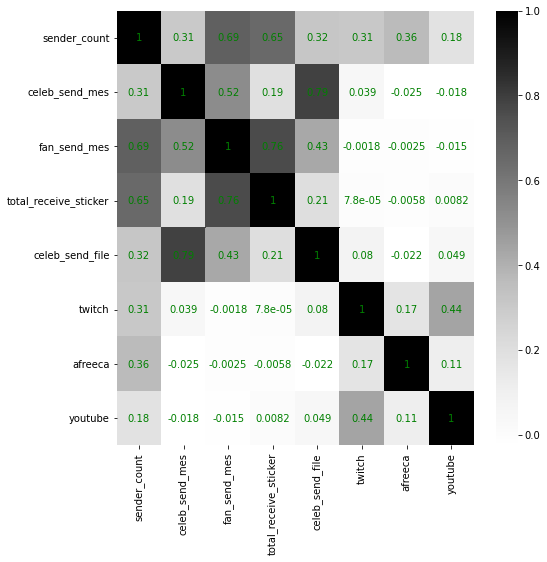

In [5]:
abc = ch_name_total.copy()
cba = abc.corr()
plt.figure(figsize=(8,8))
ax = sns.heatmap(cba, annot=True, annot_kws=dict(color='g'), cmap='Greys')
plt.show()

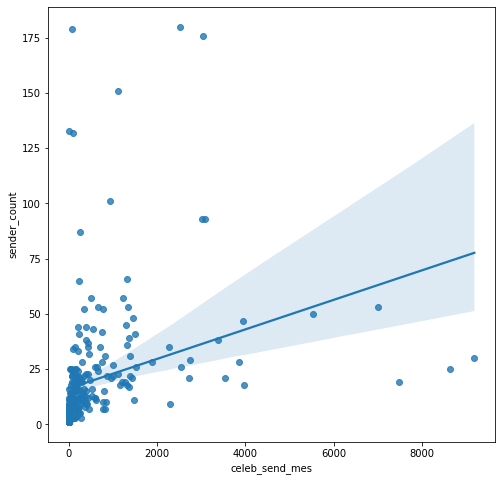

In [6]:
# 셀럽이 보낸 메세지가 많으면 채팅방 인원이 많은가?

plt.figure(figsize=(8,8))
sns.regplot(x = ch_name_total['celeb_send_mes'],y = ch_name_total['sender_count'])
plt.show()
# x = 셀럽이 보낸 메세지 , y = 채팅방 인원

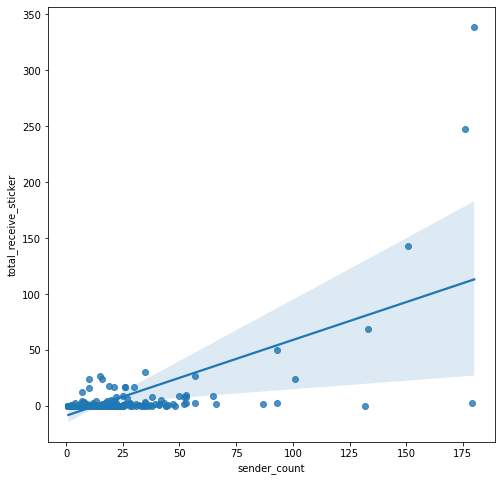

In [7]:
# 가설 : 채팅방에 들어와있는 인원이 많으면 많을수록 스티커를 많이 받을 수 있을 것이다.     

plt.figure(figsize=(8,8))
sns.regplot(x = ch_name_total['sender_count'],y = ch_name_total['total_receive_sticker'])
plt.show()
# x = 채팅방 인원 , y = 받은 스티커 수
# 채팅방 인원이 많을 수록 스티커를 많이받는가?

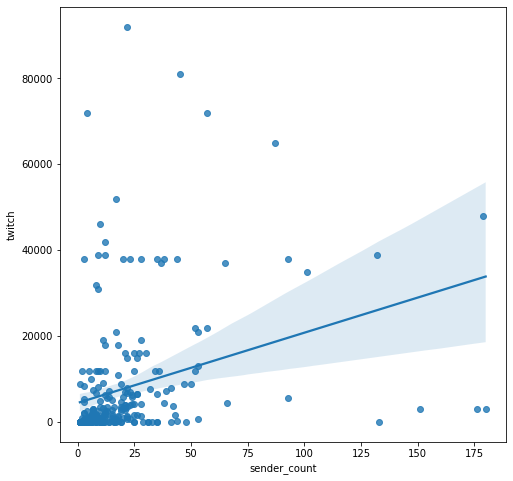

In [8]:
# 가설 : 셀럽 규모와 채팅방 인원은 비례할것이다. (트위치)

plt.figure(figsize=(8,8))
sns.regplot(x = ch_name_total['sender_count'],y = ch_name_total['twitch'])
plt.show()
# x = 채팅방 인원 , y = 트위치 팔로워 수

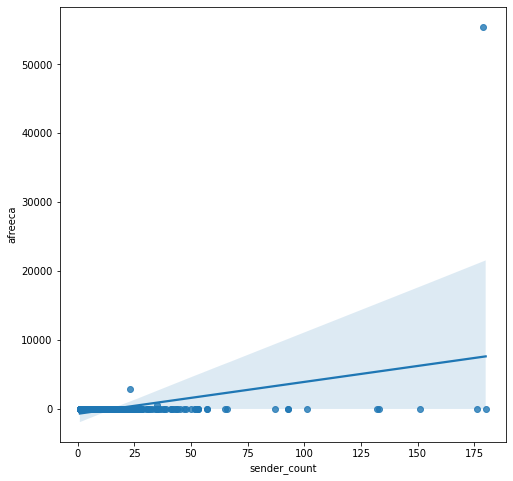

In [9]:
# 가설 : 셀럽 규모와 채팅방 인원은 비례할것이다. (아프리카)

plt.figure(figsize=(8,8))
sns.regplot(x = ch_name_total['sender_count'],y = ch_name_total['afreeca'])
plt.show()
# x = 채팅방 인원 , y = 아프리카 애청자(팔로워) 수

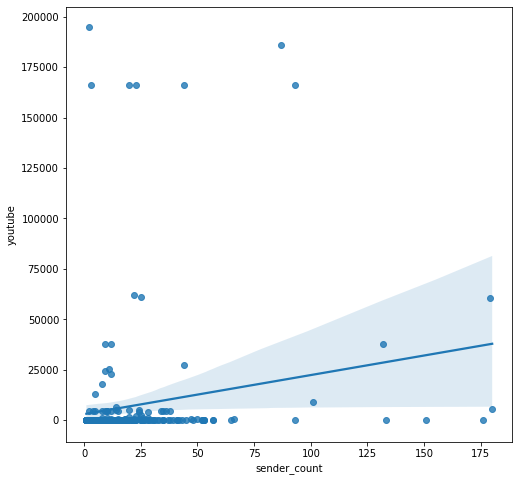

In [10]:
# 가설 : 셀럽 규모와 채팅방 인원은 비례할것이다. (유튜브)

plt.figure(figsize=(8,8))
sns.regplot(x = ch_name_total['sender_count'],y = ch_name_total['youtube'])
plt.show()
# x = 채팅방 인원 , y = 유튜브 구독자(팔로워) 수

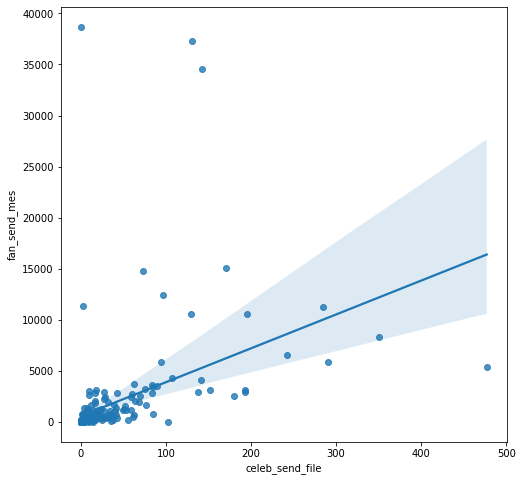

In [11]:
# 가설 : 셀럽이 사진,영상,음성(텍스트와 파일 비율)을 많이 올릴수록 팬들의 재사용율이 늘어날것이다. 

plt.figure(figsize=(8,8))
sns.regplot(x = ch_name_total['celeb_send_file'],y = ch_name_total['fan_send_mes'])
plt.show()
# x = 채팅방 인원 , y = 유튜브 구독자(팔로워) 수

In [12]:
# 가설 : 팬심을 사용하는 셀럽은 규모가 작을 것이다.


ch_name_total.describe()

# 트위치의 중앙값
# 아프리카와 유튜브는 기록된 개수가 너무 적어서 중앙값이 0이 나옴

# https://twitchtracker.com/channels/most-followers/korean?page=27
# https://twitchtracker.com/languages/Korean
# 1350등이 약 9700명의 팔로워고 트위치통계사이트를 참조한 결과 대략 3천명정도가 방송한다고 가정했을때
# 1750명이 9700명보다 낮은 팔로워를 가지고 있고

# 팬심을 이용중인 셀럽의 트위치팔로워의 3사분위수가 7222인것을 생각한다면

# 팬심을 이용중인 대부분의 셀럽들의 팔로워가 낮다고 볼 수 있다.

,sender_count,celeb_send_mes,fan_send_mes,total_receive_sticker,celeb_send_file,twitch,afreeca,youtube
count,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000
mean,20.221344,599.039526,1507.470356,5.280632,27.462451,7768.407115,232.877470,6967.237154
std,27.495859,1259.920581,4502.480978,28.465732,58.166254,14616.800254,3490.525662,29363.163869
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,26.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,156.000000,264.000000,0.000000,6.000000,1700.000000,0.000000,0.000000
75%,23.000000,538.000000,1032.000000,1.000000,24.000000,7222.000000,0.000000,232.000000
max,180.000000,9177.000000,38687.000000,339.000000,477.000000,92000.000000,55458.000000,195000.000000
